### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

### Plot ellispse

In [2]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2 as c2

# Inspired from: https://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals

def plot_cov_ellipse(cov, pos, masse=0.90, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(vals * c2.ppf(masse, 2))
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip
colors = sns.color_palette()
gg = colors[:4]

### Load Algorithms

In [3]:
from algorithms.kmeans import Kmeans
from algorithms.emgaussians import EMGaussians

### Load data

In [4]:
data = pd.read_csv("data/EMGaussian.data", sep=" ", names=["x1", "x2"])
test = pd.read_csv("data/EMGaussian.test", sep=" ", names=["x1", "x2"])

In [5]:
X_data = np.array(data)
X_test = np.array(test)

### Kmeans

In [7]:
kmeans = Kmeans()
kmeans.fit(X_data)

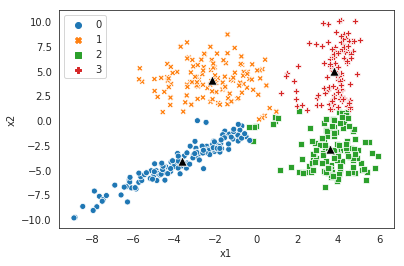

In [8]:
sns.scatterplot(x="x1", y="x2", data=data, hue=kmeans.labels, palette=gg, style=kmeans.labels)
c = kmeans.cluster_centers
sns.scatterplot(x=c[:, 0], y=c[:, 1], color=["black"], s = 85, marker="^")
#plt.savefig("./figures/kmeans_train.png")

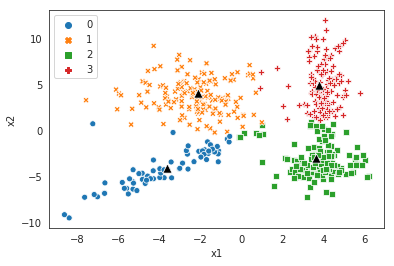

In [9]:
sns.scatterplot(x="x1", y="x2", data=test, hue=kmeans.predict(X_test), palette=gg, style=kmeans.predict(X_test))
sns.scatterplot(x=c[:, 0], y=c[:, 1], color=["black"], s = 85, marker="^")
#plt.savefig("./figures/kmeans_test.png")

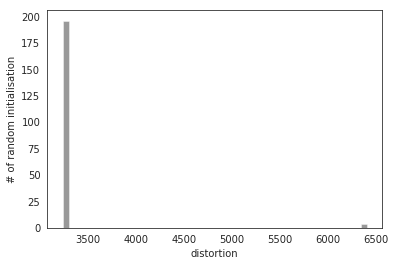

In [25]:
def plot_distortion():
    distortions = []
    for i in range(200):
        try:
            kmeans = Kmeans()
            kmeans.fit(X_data)
            distortions.append(kmeans.distortion)
        except:
            continue
    sns.distplot(distortions, kde=False, color="Black")
    plt.xlabel("distortion")
    plt.ylabel("# of random initialisation")
    plt.savefig("./figures/kmeans_distortion.png")
# plot_distortion()

### EM Gaussains (Isotropic)

In [7]:
emi = EMGaussians()
emi.fit(X_data)

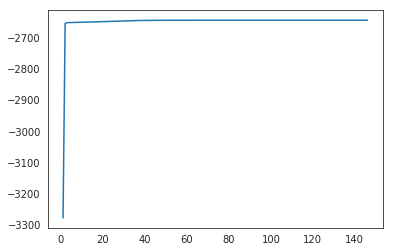

In [8]:
plt.plot(emi.log_likelihood)

In [9]:
emi.log_likelihood[-1]

-2645.5243204927647

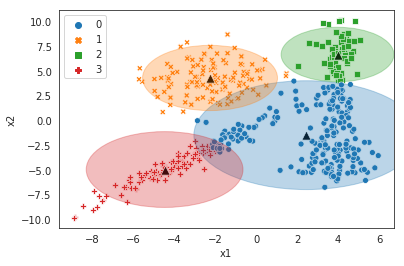

In [10]:
sns.scatterplot(x="x1", y="x2", data=data, hue=emi.latent_var, style=emi.latent_var, palette=gg)
means = emi.means.reshape(4,2)
cov = emi.sigmas
sns.scatterplot(x=means[:, 0], y=means[:, 1], color=["black"], s = 85, marker="^")
for i in range(4):
    plot_cov_ellipse(cov[i], means[i], masse=0.90, fill=True, color=gg[i], alpha=0.3)
#plt.savefig("./figures/em_iso_train.png")

-2694.099480255916

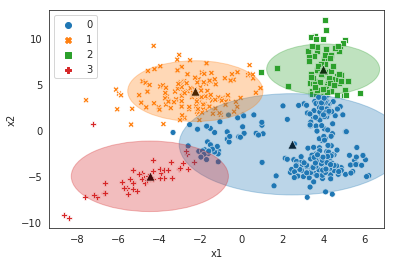

In [11]:
sns.scatterplot(x="x1", y="x2", data=test, hue=emi.predict(X_test), style=emi.predict(X_test), palette=gg)
sns.scatterplot(x=means[:, 0], y=means[:, 1], color=["black"], s = 85, marker="^")
for i in range(4):
    plot_cov_ellipse(cov[i], means[i], masse=0.90, fill=True, color=gg[i], alpha=0.3)
#plt.savefig("./figures/em_iso_test.png")
emi.log_likelihood[-1]

### EM Gaussian (general)

In [12]:
emg = EMGaussians(covariance_type="general")
emg.fit(X_data)

In [13]:
print(emg.log_likelihood[-1], emg.log_likelihood[-1] / len(X_data))

-2327.715674921845 -4.65543134984369


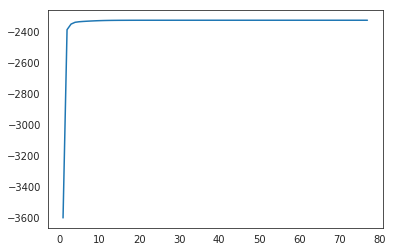

In [14]:
plt.plot(emg.log_likelihood)

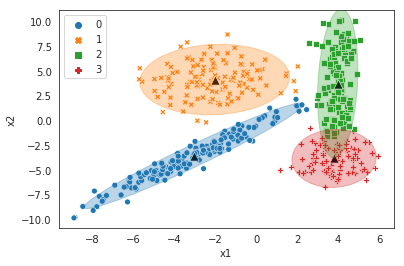

In [15]:
sns.scatterplot(x="x1", y="x2", data=data, hue=emg.latent_var, style=emg.latent_var, palette=gg)
means = emg.means.reshape(4,2)
cov = emg.sigmas
sns.scatterplot(x=means[:, 0], y=means[:, 1], color=["black"], s = 85, marker="^")
for i in range(4):
    plot_cov_ellipse(cov[i], means[i], masse=0.90, fill=True, color=gg[i], alpha=0.3)
#plt.savefig("./figures/em_general_train.png")

-2408.9781713143298

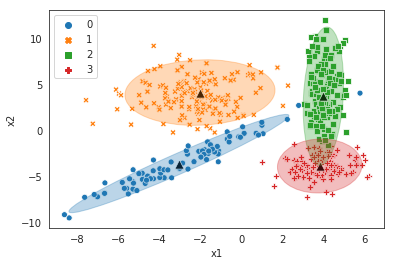

In [16]:
sns.scatterplot(x="x1", y="x2", data=test, hue=emg.predict(X_test), style=emg.predict(X_test), palette=gg)
sns.scatterplot(x=means[:, 0], y=means[:, 1], color=["black"], s = 85, marker="^")
gg[1], gg[3] = gg[3], gg[1]
for i in range(4):
    plot_cov_ellipse(cov[i], means[i], masse=0.90, fill=True, color=gg[-i], alpha=0.3)
#plt.savefig("./figures/em_general_test.png")
emg.log_likelihood[-1]